This notebook assesses the ability of the time-delay reservoir to receive a noisy signal as input and output a cleaned version of the signal.

In [1]:
"""Target is always the same sine wave. Input consists of sine wave with different levels of noise added"""
import numpy as np 
import sympy
import math
import matplotlib.pyplot as plt
import sklearn
import random
from numpy.linalg import inv
from sklearn.linear_model import Ridge
from scipy import signal
import statistics
from scipy import signal
from scipy.stats import norm
import itertools
%config InlineBackend.figure_format = 'retina'

In [3]:
#!/usr/bin/env python3
import numpy as np
import sys


class TimeDelayRC():
    """
    Note: Can only handle 1D Input
    """

    def __init__(self, N, alpha=1, beta=0.5, gamma=0.01, theta=0.3, delta_t=0.1, m_amp=0.1):
        """
        Args:
            N:          number of virtual nodes
            alpha:      scaling param TODO
            beta:       for mackey glass equation
            gamma:      input scaling
            M:          second delay
            theta:      length of subintervals
            m_amp:      mask amplitude
        """

        self.N = N
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.theta = theta
        self.m_amp = m_amp
        self.delta_t = delta_t
        # creates a mask with either value either being m_amp or - m_amp
        self.mask = self.m_amp * (2 * (np.random.uniform(low=0.0,
                                                         high=1.0, size=(1, self.N)) < 0.5) - 1)
        self.mask -= np.mean(self.mask)

#         if (M is None):
#             self.M = 2 * self.N - 3

    # =======#=======#=======#=======#=======#=======#=======#=======#=======#

    def transform_mp(self, u):
        """
        Args:
            u:          data to be multiplexed
        Returns:
            J:          mutliplexed data
        """

        # apply mask on input data
        u = np.reshape(u, (-1, 1))
        return np.dot(u, self.mask)

    # =======#=======#=======#=======#=======#=======#=======#=======#=======#

    def mg(self, X, b=0.1, n=1): #b = 0.5
        """
        Nonlinear Function, the Mackey Glass Equation
        Args:
            x:          input
            b:          scaling parameter
            n:          exponent (the higer, the more nonlinear mg becomes)
        Returns:
            output:     output of mackey glass equation
        """
        return b * (X / (1 + X**n))

    # =======#=======#=======#=======#=======#=======#=======#=======#=======#

    def calculate(self, J):
        """
        Calculate Reservoir Activity
        Args:
            J:          multiplexed input
        Returns:
            R:          matrix of reservoir history (rows being timesteps)
        """

        # due to the fact, that we have a delayed differential equation,
        # every calculation needs values from previous timesteps, thus we
        # need some sort of padding
        pad = 3

        # get number of cycles for this data
        cycles = J.shape[0]

        # array for values of virtual nodes
        VN = np.zeros((self.N))
        f0 = 0.1
        phi0 = 0.1

        # reservoir history matrix
        R = 0.1 * np.ones((pad + cycles, self.N))

        # since we introduced this padding to matrix R, we will do the same
        # to input matrix J (with empty padding), so that we can index them
        # the same way
        # furthermore, apply input scaling via gamma
        J = np.vstack((np.zeros((pad, self.N)), J)) * self.gamma

        # iterate, but leave out padding
        for i in range(pad, cycles + pad):

            # for calculating with delay values, we will need values from
            # 3 cycles steps in the past
            # apply nonlinear mackey glass equation
            ff = self.mg(R[i - 1] + J[i], b=self.beta)
            # value of first virtual node
            VN[0] = (phi0 + self.theta * ff[0]) / (1 + self.theta * self.alpha)

#             for j in range(self.N):
#                 for i in range(int(self.theta/self.delta_t)):
#                     temp = (temp + self.delta_t * ff[j])/ (1 + self.delta_t * self.alpha)
#                 VN[j] = temp

            # calculate values for the rest of the virtual nodes
            for t in range(1, self.N):
                VN[t] = (VN[t-1] + self.theta * ff[t]) / (1 + self.theta * self.alpha)
            # calculate reservoir
#             R[i] = b * (self.theta / 2 * f0 + phi0) + self.theta / 2 * VN
            R[i] = VN
            # update
            f0 = ff[self.N - 1]
            phi0 = R[i, self.N - 1]

            # progress bar
            self.update_progress(int(100 * (i) / (cycles + pad - 1)))

        # remove padding so we are left with "pure" values
        R = R[pad:]
        # np.savetxt("new.npy", R)
        return R

    def update_progress(self, pg):
        if (pg != 100):
            sys.stdout.write('\r[*]Reservoir Progress: [{0}] {1}%'.format('#'*int(pg / 2), pg))

        else:
            sys.stdout.write('\r[+]Reservoir Progress: [{0}] {1}%\n'.format('#'*int(pg / 2), pg))

        sys.stdout.flush()


def complete(data, N, Model=None):
    """
    First initiate a new instance of the MultiDelayCoupledRC, multiplex the
    input and finally apply reservoir
    Returns the Resrevoir Activity, which can be used for a lineary readout
    """

    if (Model is None):
        # create Time Delay Reservoir Class
        Model = TimeDelayRC(N)

    # multiplex
    J = Model.transform_mp(data)
    # calculate reservoir activity, measure time
    X = Model.calculate(J)

    # return reservoir activity matrix
    return X, Model

In [4]:

#!/usr/bin/env python3

import numpy as np

#=======#=======#=======#=======#=======#=======#=======#=======#=======#======#
#=======#=======#=======#=======#=======#=======#=======#=======#=======#======#
#=======#=======#=======#=======#=======#=======#=======#=======#=======#======#

def generate_NARMA10(N, delay=0):
    """
    Arguments:
        N               number of values
        delay           delay in NARMA10 (the higher, the harder, more memory
                            needed)
    Returns:
        u               random input values
        y               corresponding NARMA10 values
    """

    while True:
        # random input values
        u = 0.5 * np.random.uniform(low=0.0, high=1.0, size=(N+1000))

        # output arrays
        y_base = np.zeros(shape=(N+1000))
        y = np.zeros(shape=(N, delay+1))

        # calculate the intermediate output
        for i in range(10, N+1000):

            # NARMA10 equation
            y_base[i] = 0.3 * y_base[i-1] + 0.05 * y_base[i-1] * \
                np.sum(y_base[i-10:i]) + 1.5 * u[i-1] * u[i-10] + 0.1

        # delete the first 1000 values for u and y, since we want to take
        # values of the system, after we allowed it to warm up
        u = u[1000:]
        for curr_delay in range(0, delay+1):
            y[:, curr_delay] = y_base[1000 - curr_delay : len(y_base)-curr_delay]

        # if all values of y are finite, return them with the corresponding
        # inputs
        if np.isfinite(y).all():
            return (u, y)

        # otherwise, try again. You random numbers were "unlucky"
        else:
            print('...[*] Divergent time series. Retry...')

In [5]:
def addNoise(waveform, target_SNR_dB):
    """
    Argument:
        waveform: numpy array of points representing amplitudes of wave in time
        target_SNR_dB: desired average signal to noise ratio in decibels
        
    Returns:
        output_waveform: wave with noise included """
    
    # calculate signal power
    signal_watts = waveform **2
   # signal_dB = 10 * np.log10(signal_watts)
    signal_avg_watts = np.mean(signal_watts) # average signal power
    #signal_avg_dB = np.mean(signal_dB)
    #noise_avg_dB = signal_avg_dB - target_SNR_dB # deduce noise average power
   # noise_avg_watts = 10 ** (noise_avg_dB / 10)
    target_SNR = 10 ** ((target_SNR_dB) / 10)
    noise_avg_watts = signal_avg_watts / target_SNR
    mean_noise = 0
    noise_waveform = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(waveform)) # generate noise data
    output_waveform = list(map(lambda x, y: x + y, waveform, noise_waveform))
    return output_waveform


def computePower(waveform):
    """
    Argument:
        waveform: array of points representing amplitudes of wave in time
    
    Returns:
        Power_avg_watts: average power in watts"""
    amp_avg = np.mean(waveform) 
    #Power_watts = np.array(list(map(lambda x: (x - amp_avg) ** 2, waveform)))
    #Power_avg_watts = amp_avg ** 2 + np.mean(Power_watts) # average signal power
    Power_avg_watts = np.mean(waveform ** 2)
    return Power_avg_watts
def computeSNR(waveform_actual, waveform_target):
    """
    Argument:
        waveform_actual: waveform with noise
        waveform_target: waveform without noise
    
    Returns:
        SNR: signal to noise ratio"""
    noise_wave = np.array(list(map(lambda x, y: x - y, waveform_actual, waveform_target)))
    signal_power = computePower(waveform_target)
    noise_power = computePower(noise_wave)
    SNR = 10 * math.log10(signal_power / noise_power)
    return SNR

In [6]:
## generate values of sine wave
def generate_sine(samples, time, frequency = 1):
    """
    Arguments:
        samples: number of points to generate
        time: units of time over which samples are taken
        frequency: frequency of sine wave
    
    Returns:
        s_target: target sine waveform
        """
    t = np.linspace(0, time, samples)
    s_target = np.sin(frequency * 2 * np.pi * t)
    return s_target
def normalize(vector):
    """Argument:
            vector: array that we want to normalize
            
        Returns:
            output_vector: normalized vector (magnitude is 1)"""
    magnitude = math.sqrt(np.dot(vector, vector))
    if magnitude == 0: # corner case
        return [0] * len(vector)
    output_vector = [x / magnitude for x in vector]
    return output_vector


In [7]:
# function generates one waveform


# calls generate_waveform() to generate all different waveforms and append them together in an array
def generate_training_waveform(time, samples, SNR_min, SNR_max, training_cycles, testing_cycles, training_iterations, testing_iterations):
    """
    Arguments:
        time: amount of time over which the waveform exists
        samples: number of waveform points
        runs: the number of different composite waveforms that will be generated
        SNR_min: minimum SNR on which the reservoir will be trained
        SNR_max: maximum SNR on which the reservoir will be trained
    
    Return:
        training_waveform_global: waveform for training the reservoir containing noise
      """
    SNR_min
    training_waveform_global = [] # initialize output training waveform
    target_waveform_global = [] # initialize output training waveform
    target_waveform_local = generate_sine(samples, time)
    training_runs = int(training_cycles / samples) # how many different waveforms to create for training
    testing_runs = int(testing_cycles / samples) # how many different waveforms to create for testing
    SNR_increment_training = (SNR_max - SNR_min) / training_runs
    SNR_increment_testing = (SNR_max - SNR_min) / testing_runs
    # for training
    for i in range(training_iterations):
        SNR_current = SNR_min
        for i in range(training_runs): # generated waveforms centered around different mean frequencies
            training_waveform_local = addNoise(target_waveform_local, SNR_current)
            training_waveform_global = np.concatenate([training_waveform_global, training_waveform_local])
            target_waveform_global = np.concatenate([target_waveform_global, target_waveform_local])
            SNR_current += SNR_increment_training # update current SNR
        
     # for testing
    SNR_testing = [] # array of SNR values
    SNR_current = SNR_min 
    training_waveform_local = addNoise(target_waveform_local, SNR_current)
    training_waveform_global = np.concatenate([training_waveform_global, training_waveform_local])
    target_waveform_global = np.concatenate([target_waveform_global, target_waveform_local])
    for i in range(testing_iterations):
        SNR_current = SNR_min 
        for i in range(testing_runs): 
            training_waveform_local = addNoise(target_waveform_local, SNR_current)
            training_waveform_global = np.concatenate([training_waveform_global, training_waveform_local])
            target_waveform_global = np.concatenate([target_waveform_global, target_waveform_local])
            SNR_testing.append(SNR_current)
            SNR_current += SNR_increment_testing # update current SNR
    
        # washout?
    return (training_waveform_global, target_waveform_global, SNR_testing, training_runs, testing_runs)
    



In [14]:
# paramters
time = 10
samples = 1500
min_freq = 0
max_freq = 20
SNR_min = -20#20
SNR_max = 5 #50
training_iterations = 4
testing_iterations = 5
train_cycles=15000
test_cycles= 30000
def signal_Cleaner2_TEST(N=500, train_cycles=15000, test_cycles= 30000, warmup_cycles=0):
    # generate waveforms and split into training and testing
    X, Y, SNR_input, training_runs, testing_runs = generate_training_waveform(time, samples, SNR_min, SNR_max, train_cycles, test_cycles, training_iterations, testing_iterations)
    train_cycles = train_cycles * training_iterations
    test_cycles = test_cycles * testing_iterations
    X_train, Y_train = X[:train_cycles+warmup_cycles], Y[:train_cycles+warmup_cycles]
    X_test, Y_test = X[warmup_cycles+train_cycles:], Y[warmup_cycles+train_cycles:]
    dimension = len(Y_train)
    # get reservoir activity for trainings data and the initialized model
    R_Train, model = complete(X_train, N)
    # remove warmup values
    R_Train = R_Train[warmup_cycles:]

    # calcualte weights, using pseudoinverse
    R_inverse = np.linalg.pinv(np.transpose(R_Train)) # Moore-Penrose pseudo-inverse
    # calcualte weights, using pseudoinverse
    weights =  np.dot(np.linalg.pinv(R_Train), Y_train[warmup_cycles:])
    k = 0.0001
    R_Train = np.transpose(R_Train)
    #dimension = len(np.matmul(np.transpose(R_Train), R_Train))
    #weights = np.transpose(np.matmul(Y_train, np.matmul(inv(np.matmul(np.transpose(R_Train), R_Train) + k * np.identity(dimension)), np.transpose(R_Train))))

    # get reservoir activity for test data, and reuse model, since the model
    # mask is generated randomly (and we need consistend models)
    R_Test, _ = complete(X_test, N, model)
    # calculate prediction values
    Yhat = np.matmul(R_Test, weights) #np.dot(R_Test, weights)

    # for calculating the NRMSE, dont use the first 75 values, since the model
    # first needs to get "swinging"
    y_consider = Y_test[samples:] # so you get the beginning of next wave
    yhat_consider = np.transpose(Yhat)[samples:]
    x_consider = X_test[samples:]
    
#     # calculate normalized root mean squared error
#     NRMSE = np.sqrt(np.divide(                          \
#         np.mean(np.square(y_consider-yhat_consider)),   \
#         np.var(y_consider)))
  
    return y_consider, yhat_consider, x_consider, X_test, Y_test, SNR_input, training_runs, testing_runs


#=======#=======#=======#=======#=======#=======#=======#=======#=======#======#
#=======#=======#=======#=======#=======#=======#=======#=======#=======#======#
#=======#=======#=======#=======#=======#=======#=======#=======#=======#======#
y_consider, yhat_consider, x_consider, X_test, Y_test, SNR_input, training_runs, testing_runs = signal_Cleaner2_TEST()

[+]Reservoir Progress: [##################################################] 100%
[+]Reservoir Progress: [##################################################] 100%


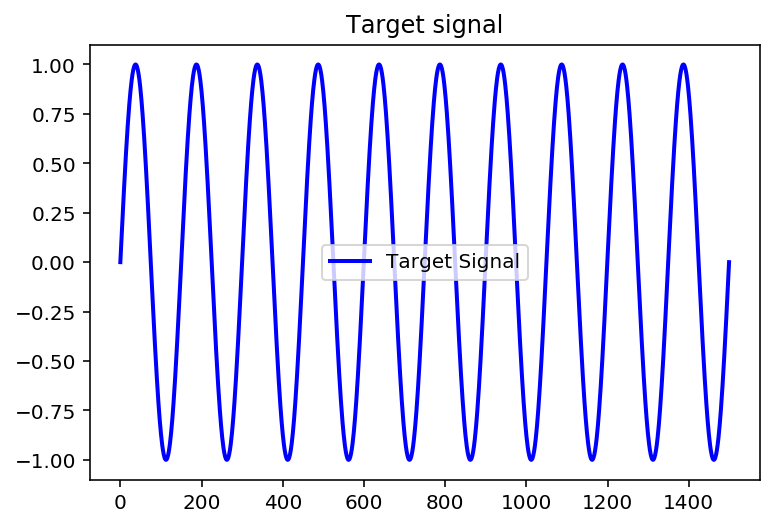

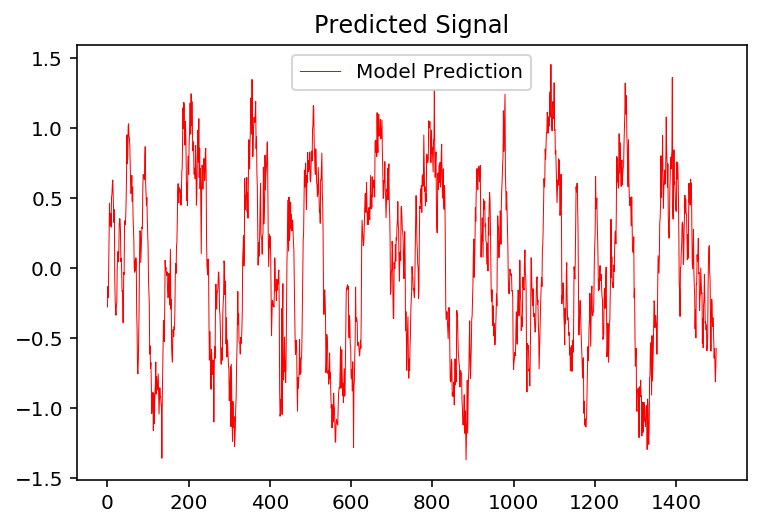

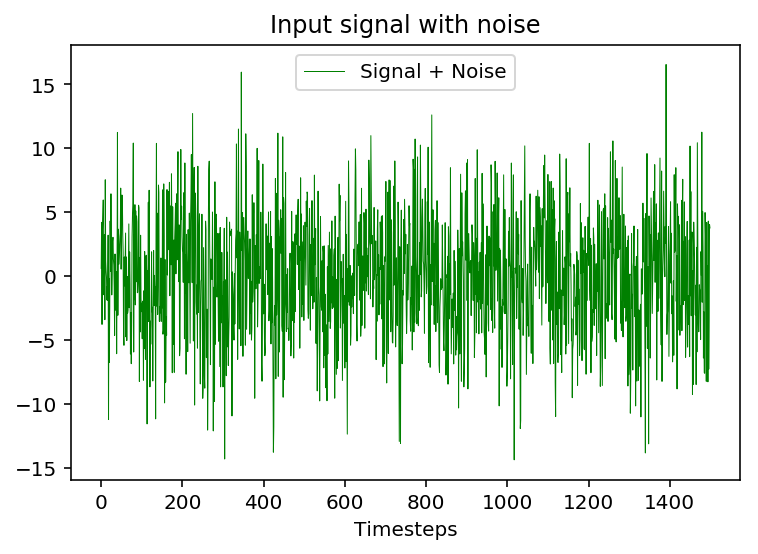

SNR of signal + noise:  -16.26061771114373
SNR of predicted signal:  0.625792729555207


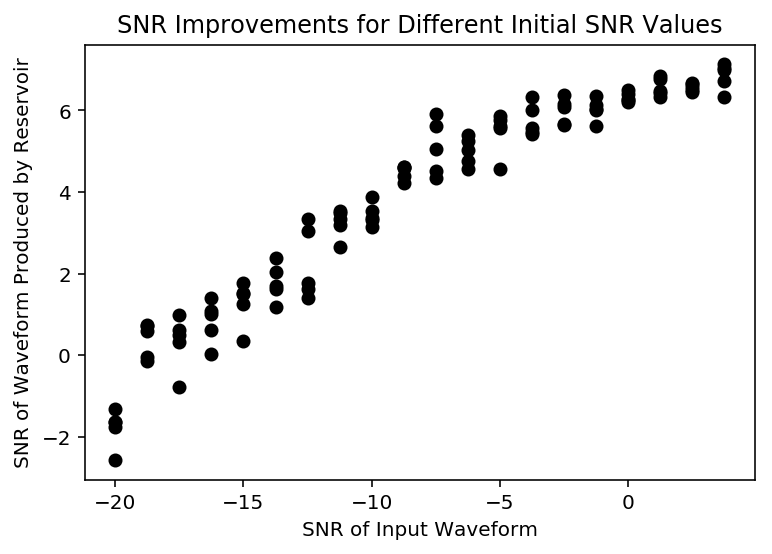

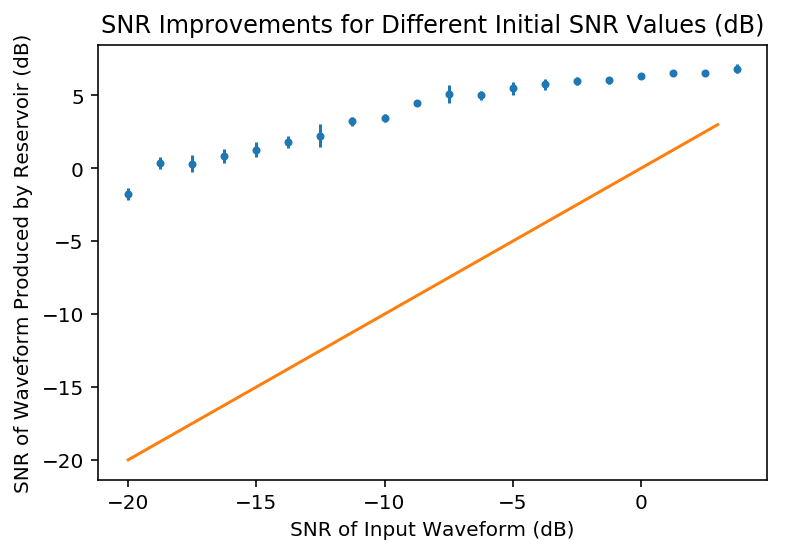

In [19]:
# plot results
plt.figure("Prediction Plot 1")
plt.plot(y_consider[4500:6000], color="blue", linewidth=2, label="Target Signal")
plt.title("Target signal")
plt.legend()
plt.show()
plt.plot(yhat_consider[4500:6000], color="red", linewidth=0.5, linestyle='-', label="Model Prediction")
plt.legend()
plt.title("Predicted Signal")
plt.show()
plt.plot(x_consider[4500:6000], color="green", linewidth=0.5, linestyle='-', label="Signal + Noise")
plt.xlabel("Timesteps")
plt.legend()
plt.title("Input signal with noise")
plt.show()

print("SNR of signal + noise: ", computeSNR(x_consider[4500:6000], y_consider[4500:6000]))
print("SNR of predicted signal: ", computeSNR(yhat_consider[4500:6000], y_consider[4500:6000]))
SNR_output = [] # SNR of the signal being output by the reservoir
i = 0
while i < len(y_consider):
    SNR_output.append(computeSNR(yhat_consider[i:i + samples], y_consider[i:i + samples]))
    i += samples


plt.plot(SNR_input, SNR_output, 'o', color = "black")
plt.xlabel("SNR of Input Waveform")
plt.ylabel("SNR of Waveform Produced by Reservoir")
plt.title("SNR Improvements for Different Initial SNR Values")
plt.show()



SNR_output_mean = [] # mean SNR output by reservoir for a given input SNR value
STD = []
input_SNR_short = []
# SNR_input1 = SNR_input
# SNR_output1 = SNR_output
# SNR_input_log = list(map(lambda x: 10 * math.log10(x), SNR_input1))
# SNR_output_log = list(map(lambda x: 10 * math.log10(x), SNR_output1))

for i in range(testing_runs):
    select_input = np.array(list(itertools.islice(SNR_input[i:], 0, None, testing_runs)))
    select_output = np.array(list(itertools.islice(SNR_output[i:], 0, None, testing_runs)))
    SNR_output_mean.append(np.mean(select_output))
    STD.append(np.std(select_output))

plt.errorbar(SNR_input[0:testing_runs], SNR_output_mean, STD, linestyle = "None", marker = ".")
min_dB = int(min(SNR_input[0:testing_runs]))
max_dB = int(max(SNR_input[0:testing_runs]))
t = np.linspace(min_dB, max_dB, max_dB - min_dB)
plt.plot(t,t)
plt.xlabel("SNR of Input Waveform (dB)")
plt.ylabel("SNR of Waveform Produced by Reservoir (dB)")
plt.title("SNR Improvements for Different Initial SNR Values (dB)")
plt.show()